In [2]:
import random
from Bio.Align import substitution_matrices
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA

h:\study\6\ML\project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


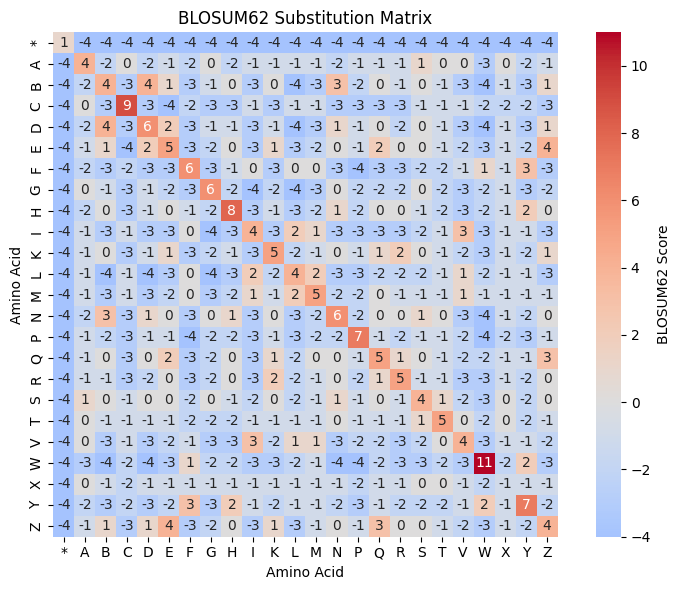

In [3]:
blosum62 = substitution_matrices.load("BLOSUM62")
blosum_amino_acids = sorted(blosum62.alphabet)

matrix = np.zeros((len(blosum_amino_acids), len(blosum_amino_acids)))
for i, aa1 in enumerate(blosum_amino_acids):
    for j, aa2 in enumerate(blosum_amino_acids):
        matrix[i, j] = blosum62[aa1][aa2]

plt.figure(figsize=(8, 6))
sns.heatmap(
    matrix,
    xticklabels=blosum_amino_acids,
    yticklabels=blosum_amino_acids,
    cmap="coolwarm",
    center=0,
    square=True,
    annot=True,
    fmt=".0f",
    cbar_kws={"label": "BLOSUM62 Score"},
)

plt.title("BLOSUM62 Substitution Matrix")
plt.xlabel("Amino Acid")
plt.ylabel("Amino Acid")
plt.tight_layout()
plt.show()

In [4]:
# Hydrophobicity scale (Kyte-Doolittle)
hydrophobicity = {
    "A": 1.8,
    "C": 2.5,
    "D": -3.5,
    "E": -3.5,
    "F": 2.8,
    "G": 0.4,
    "H": -3.2,
    "I": 4.5,
    "K": -3.9,
    "L": 3.8,
    "M": 1.9,
    "N": -3.5,
    "P": -1.6,
    "Q": -3.5,
    "R": -4.5,
    "S": -0.8,
    "T": -0.7,
    "V": 4.2,
    "W": -0.9,
    "Y": -1.3,
    "B": -3.5,  # Avg of D (-3.5) and N (-3.5)
    "Z": -3.5,  # Avg of E (-3.5) and Q (-3.5)
    "J": 4.15,  # Avg of I (4.5) and L (3.8)
    "X": 0.0,   # Unknown, assumed neutral
    "U": 0.7,   # Selenocysteine, similar to C (estimated)
    "O": -3.9   # Pyrrolysine, similar to K (estimated)
}

blosum62 = substitution_matrices.load("BLOSUM62")
amino_acids = list(hydrophobicity.keys())


def substitute_with_constraints(
    sequence, num_substitutions=3, min_score=0, max_hydro_diff=1.0
):
    seq_list = list(sequence)
    positions = random.sample(range(len(seq_list)), num_substitutions)

    for pos in positions:
        old_aa = seq_list[pos]
        old_hydro = hydrophobicity[old_aa]
        # Filter by BLOSUM62 score and hydrophobicity
        candidates = [
            aa
            for aa in amino_acids
            if blosum62[old_aa][aa] >= min_score
            and abs(hydrophobicity[aa] - old_hydro) <= max_hydro_diff
            and aa != old_aa
        ]
        if candidates:
            new_aa = random.choice(candidates)
            seq_list[pos] = new_aa

    return "".join(seq_list)


def augment_sequence(
    sequence,
    num_substitutions=[1, 2, 3],
    num_mutations=[5, 4, 3],
    min_score=0,
    max_hydro_diff=1.0,
    random_seed=None,
):
    """Augment a sequence by substituting amino acids with constraints."""
    random.seed(random_seed)
    new_seq_list = []

    for i in range(len(num_substitutions)):
        current_substitution = num_substitutions[i]
        current_mutation = num_mutations[i]

        for _ in range(current_mutation):
            while True:
                new_seq = substitute_with_constraints(
                    sequence,
                    num_substitutions=current_substitution,
                    min_score=min_score,
                    max_hydro_diff=max_hydro_diff,
                )
                if new_seq not in new_seq_list and new_seq != sequence:
                    new_seq_list.append(new_seq)
                    break

    return new_seq_list

In [5]:
original_seq = "MAKVRTKDVMEQFNLELISGEEGINRPITMSDLSRPGIEIAGYFTYYPRERVQLLGK"
new_seqs = augment_sequence(
    original_seq,
    num_substitutions=[1, 2, 3],
    num_mutations=[3, 2, 1],
    min_score=0,
    max_hydro_diff=1,
    random_seed=41,
)

print(f"Original Sequence: {original_seq}")
print("-" * 50)
for i, seq in enumerate(new_seqs, 1):
    # Find positions where the sequence differs
    diffs = [j for j, (a, b) in enumerate(zip(original_seq, seq)) if a != b]
    print(f"\n Augmented Sequence {i}: {seq}")
    print(f"Changes: {len(diffs)} substitutions at positions {diffs}")
print("-" * 50)
print(f"Total Augmented Sequences: {len(new_seqs)}")

Original Sequence: MAKVRTKDVMEQFNLELISGEEGINRPITMSDLSRPGIEIAGYFTYYPRERVQLLGK
--------------------------------------------------

 Augmented Sequence 1: MAKVRTKDVMEQFNLELISGEEGIHRPITMSDLSRPGIEIAGYFTYYPRERVQLLGK
Changes: 1 substitutions at positions [24]

 Augmented Sequence 2: MAKVRTKDVMEQFNFELISGEEGINRPITMSDLSRPGIEIAGYFTYYPRERVQLLGK
Changes: 1 substitutions at positions [14]

 Augmented Sequence 3: MAKVRTKDVMEQFNLELISGEEGIQRPITMSDLSRPGIEIAGYFTYYPRERVQLLGK
Changes: 1 substitutions at positions [24]

 Augmented Sequence 4: MAKVRTKDVMEQFNLELITGEEGINRPITMSDLSRPGIEIAGYFSYYPRERVQLLGK
Changes: 2 substitutions at positions [18, 44]

 Augmented Sequence 5: MAKVRTKDVMEQFNLELISGEEGINRPITMSDLSRPGIEIAGYFTYWPRERVQLVGK
Changes: 2 substitutions at positions [46, 54]

 Augmented Sequence 6: MAKVRTKDVMEQFNLNLISGEEGINRPITMSDLSRPGIEIAGWFTYYPRDRVQLLGK
Changes: 3 substitutions at positions [15, 42, 49]
--------------------------------------------------
Total Augmented Sequences: 6


In [11]:
def plot_pca_results(pca_result, sequences, augmented_sequences, colors):
    plt.figure(figsize=(8, 6))

    offset = 0
    for i, (seq, aug_seqs, color) in enumerate(
        zip(sequences, augmented_sequences, colors)
    ):
        # Plot original sequence
        plt.scatter(
            pca_result[offset, 0],
            pca_result[offset, 1],
            c=color,
            marker="*",
            s=200,
            label=f"Original Sequence {i+1}",
        )

        # Plot augmented sequences
        for j in range(1, len(aug_seqs) + 1):
            plt.scatter(
                pca_result[offset + j, 0],
                pca_result[offset + j, 1],
                c=color,
                alpha=0.6,
                s=40,
                label=f"Augmented Sequence {i+1}" if j == 1 else None,
            )

        offset += len(aug_seqs) + 1

    plt.title("PCA of Protein Sequence Embeddings")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()


def get_embeddings(sequences, tokenizer, model, device):
    embeddings = []
    for seq in sequences:
        inputs = tokenizer(seq, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).cpu()
        embeddings.append(embedding)
    return torch.cat(embeddings, dim=0).numpy()

Using device: cuda


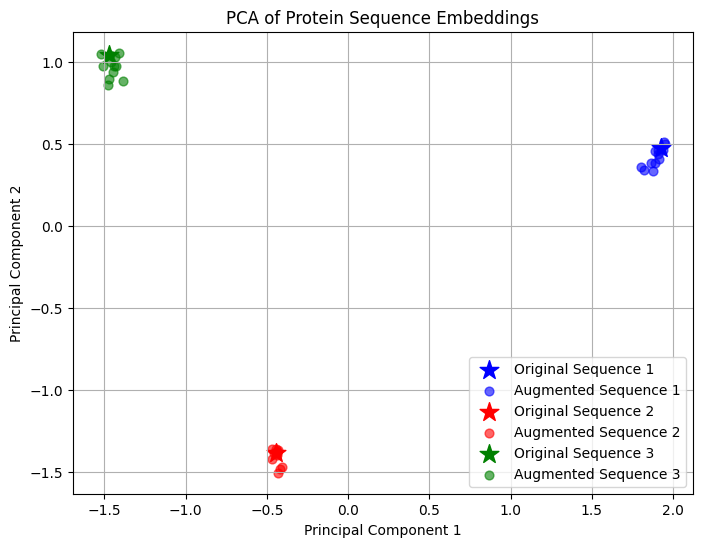

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = AutoModel.from_pretrained(
    "facebook/esm2_t6_8M_UR50D", add_pooling_layer=False
).to(device)

# Sequences
sequences = [
    "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG",
    "MAKVRTKDVMEQFNLELISGEEGINRPITMSDLSRPGIEIAGYFTYYPRERVQLLGK",
    "MGSSHHHHHHSSGLVPRGSHMASMTGGQQMGRGSEFDDDDKMQTIEEVLHKAIELAKVGVDSVEEAKKVLAKLLDKEK",
]

# Generate augmented sequences
aug_params = {
    "num_substitutions": [1, 2, 3],
    "num_mutations": [5, 4, 3],
    "min_score": 0,
    "max_hydro_diff": 1,
    "random_seed": 42,
}

augmented_sequences = [augment_sequence(seq, **aug_params) for seq in sequences]

all_sequences = []
for seq, aug_seqs in zip(sequences, augmented_sequences):
    all_sequences.extend([seq] + aug_seqs)

embeddings = get_embeddings(all_sequences, tokenizer, model, device)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

plot_pca_results(pca_result, sequences, augmented_sequences, ["blue", "red", "green"])